# Random Forest Strategy (Track 1)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import joblib
from contextlib import contextmanager
from tqdm import tqdm 
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, ParameterGrid
from sklearn.calibration import CalibratedClassifierCV
import shap
from arch.bootstrap import IIDBootstrap
from scipy.stats import ks_2samp 
from statsmodels.stats.diagnostic import acorr_ljungbox 
from statsmodels.stats.multitest import multipletests
from scipy.stats import wilcoxon 

In [411]:
np.random.seed(42) # Set random seed for reproducibility

In [ ]:
def compute_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def calculate_momentum(data, window=14):
    momentum = data['Close'].diff(window)
    return momentum


def get_z_score(series, window):
    """Calculate the z-score of a series over a rolling window."""
    return (series - series.rolling(window).mean()) / series.rolling(window).std()


def get_max_posneg_ratio(df):
    max_posneg_ratios = []
    
    for i in range(len(df)):
        pos_ratio = df['positive_ratio'].iloc[i]
        neg_ratio = df['negative_ratio'].iloc[i]
        
        if pos_ratio != neg_ratio:
            
            if pos_ratio > neg_ratio:
                max_posneg_ratios.append(pos_ratio)
            else:
                max_posneg_ratios.append(-1*neg_ratio)
                
        else:
            max_posneg_ratios.append(0)
            
    max_posneg_ratios = np.array(max_posneg_ratios)
    return max_posneg_ratios


def get_log_pos_neg_ratio(df):
    log_pos_neg_ratios = []
    
    for i in range(len(df)):
        pos_neg_ratio = df['pos/neg_ratio'].iloc[i]
        if pos_neg_ratio != 0:
            log_pos_neg_ratios.append(np.log(pos_neg_ratio))
        else:
            log_pos_neg_ratios.append(0)
    log_pos_neg_ratios = np.array(log_pos_neg_ratios)
    return log_pos_neg_ratios


def calculate_sharpe_ratio(daily_returns, annual_risk_free_rate=0.05, mode='252'):
    """
    Calculate the Sharpe Ratio of a portfolio.
    
    Parameters:
    daily_returns (pd.Series): Daily returns of the portfolio.
    annual_risk_free_rate (float): Annual risk-free rate (default is 5%).
    mode (str): '365' for daily returns, '252' for trading days (default is '252').
    
    Returns:
    float: Sharpe Ratio.
    """
    if mode == '365':
        risk_free_rate = annual_risk_free_rate / 365
        excess_daily_returns = daily_returns - risk_free_rate
        sharpe_ratio = np.sqrt(365) * excess_daily_returns.mean() / excess_daily_returns.std()
    elif mode == '252':
        risk_free_rate = annual_risk_free_rate / 252
        excess_daily_returns = daily_returns - risk_free_rate
        sharpe_ratio = np.sqrt(252) * excess_daily_returns.mean() / excess_daily_returns.std()
    else:
        raise ValueError("Invalid mode. Use '365' for daily returns or '252' for trading days.")
    
    return sharpe_ratio


def simulate_strategy(df, initial_cash=100_000, hold_days=14, trading_fee=0.001):
    cash = initial_cash
    shares = 0
    position_open = False
    entry_index = None
    position_type = None  # Can be 'long' or 'short'
    entry_indices = []

    portfolio_values = []

    for i in range(len(df)):
        current_price = df.iloc[i]['Close']
        signal = df.iloc[i]['Signal']

        # Close long position after hold_days
        if position_open and position_type == 'long' and (i - entry_index >= hold_days):
            cash = shares * current_price * (1 - trading_fee)  # deduct trading fee
            shares = 0
            position_open = False
            position_type = None

        # Close short position after hold_days
        elif position_open and position_type == 'short' and (i - entry_index >= hold_days):
            cost_to_close = shares * current_price
            cash += (initial_cash - cost_to_close)  # profit/loss from shorting
            shares = 0
            position_open = False
            position_type = None

        # Open long position
        if not position_open and signal == 1:
            shares = cash / (current_price*(1 + trading_fee))  # buy shares
            cash = 0
            position_open = True
            entry_index = i
            position_type = 'long'

        # Open short position
        elif not position_open and signal == -1:
            shares = cash / current_price  # simulate shorting by "borrowing" shares
            position_open = True
            entry_index = i
            position_type = 'short'
            # Keep cash as it is — you receive it from selling the borrowed shares

        # Calculate portfolio value
        if position_open:
            if position_type == 'long':
                portfolio_value = shares * current_price
            elif position_type == 'short':
                # Unrealized value: assume you need to buy back the borrowed shares
                cost_to_close = shares * current_price
                portfolio_value = cash + (initial_cash - cost_to_close)
        else:
            portfolio_value = cash

        entry_indices.append({entry_index:position_type})
        portfolio_values.append(portfolio_value)

    df['portfolio_value'] = portfolio_values
    return df, entry_indices


In [ ]:
delta = 5
w = 20

In [ ]:
H = 5

# BTC-USD data was originally downloaded from Yahoo Finance using yf.download, and saved as a CSV file.
# Since then the API has become subscription-based, so we use a local CSV file instead.
BTC = pd.read_csv('BTC-USD.csv', header=[0, 1, 2])
df = BTC.copy()
df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.date
df = df[['Close', 'Open', 'Volume', 'Date']]
df.columns = ['Close', 'Open', 'Volume', 'Date'] # get rid of the annoying index header
df[f'Close_z{w}'] = get_z_score(df['Close'], w)
df[f'{delta}_day_returns'] = df['Close'].pct_change(periods=delta)  # returns for the past 5 days
df[f'Close-MA_{w}'] = df['Close'] - df['Close'].rolling(w).mean()
df[f'Open_Close_diff'] = df['Open'] - df['Close']

df[f'Volume_z{w}'] = get_z_score(df['Volume'], w) 
df[f'{delta}_Day_Delta_Volume'] = df['Volume'].diff(periods=delta)
df[f'Volume-MA_{w}'] = df['Volume'] - df['Volume'].rolling(w).mean()

df['RSI'] = compute_rsi(df, window=w)
df[f'{delta}_Day_Delta_RSI'] = df['RSI'].diff(periods=delta)
df['RSI-50'] = df['RSI'] - 50

df['Momentum'] = df['Close'].diff(periods=w)
df[f'{delta}_Day_Delta_Momentum'] = df['Momentum'].diff(periods=delta)

df[f'{w}_day_volatility'] = df['Close'].rolling(w).std()

# Target variable
df[f"{H}_day_returns"] = df['Close'].pct_change(periods=H).shift(-H)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Close,Open,Volume,Date,Close_z20,5_day_returns,Close-MA_20,Open_Close_diff,Volume_z20,5_Day_Delta_Volume,Volume-MA_20,RSI,5_Day_Delta_RSI,RSI-50,Momentum,5_Day_Delta_Momentum,20_day_volatility
0,917.585999,919.325989,131958000,2017-01-26,0.837456,0.057561,38.758301,1.739990,-0.181901,20800000.0,-12221405.2,51.841101,6.830502,1.841101,15.385010,91.921021,46.281004
1,919.750000,923.223022,125594000,2017-01-27,0.863882,0.075317,40.364053,3.473022,-0.183891,9021000.0,-10887604.4,51.349728,7.852353,1.349728,11.164978,108.242004,46.724049
2,921.590027,923.911011,68979600,2017-01-28,0.884042,0.097885,41.684528,2.320984,-1.036235,-4609000.0,-63015234.0,51.258524,9.694324,1.258524,10.391052,133.218994,47.152226
3,919.495972,923.418030,60851700,2017-01-29,0.812133,0.120081,38.757074,3.922058,-1.068587,-50497300.0,-67091869.4,52.049928,22.349145,2.049928,16.667969,278.710938,47.722548
4,920.382019,923.047974,78227296,2017-01-30,0.809591,0.133116,39.007971,2.665955,-0.750703,-42603704.0,-47837238.2,51.577679,12.479007,1.577679,12.703003,124.541016,48.182290


In [ ]:
daily_entry_df = pd.read_csv('./daily_entry_df.csv')
daily_entry_df.rename(columns={'date': 'Date'}, inplace=True)
daily_entry_df['Date'] = pd.to_datetime(daily_entry_df['Date'])
daily_entry_df['Date'] = daily_entry_df['Date'].dt.date

log_pos_neg_ratios = get_log_pos_neg_ratio(daily_entry_df)
daily_entry_df['log_pos/neg_ratio'] = log_pos_neg_ratios


daily_entry_df['activity'] = daily_entry_df['total'] 
daily_entry_df[f'{delta}_day_activity_pct_change'] = daily_entry_df['total'].pct_change(periods=delta)
daily_entry_df[f'activity_z{w}'] = get_z_score(daily_entry_df['total'], w)

daily_entry_df[f'{delta}_day_delta_polarity'] = daily_entry_df['polarity'].diff(periods=delta)
daily_entry_df[f'{w}_day_z_score_polarity'] = (daily_entry_df['polarity'] - daily_entry_df['polarity'].rolling(w).mean()) / daily_entry_df['polarity'].rolling(w).std()


max_posneg_ratios = get_max_posneg_ratio(daily_entry_df)
daily_entry_df['max_posneg_ratio'] = max_posneg_ratios

daily_entry_df['polarity_x_activity'] = daily_entry_df['polarity'] * np.log1p(daily_entry_df['activity']) 
daily_entry_df['polarity_t-1'] = daily_entry_df['polarity'].shift(1)
daily_entry_df['polarity_t-2'] = daily_entry_df['polarity'].shift(2)

In [418]:
# We only care about the dates that are in both dataframes, in recent times it will not make a difference
df3 = pd.merge(daily_entry_df, df, on='Date', how='inner') 
df3.drop(columns=['total', 'positive', 'negative', 'neutral', 'pos/neg_ratio', 'positive_ratio', 'negative_ratio', 'RSI', 'Volume', 'Open'], inplace=True)
df3.dropna(inplace=True)
df3.reset_index(drop=True, inplace=True)
df3.head()

,polarity,Date,log_pos/neg_ratio,activity,5_day_activity_pct_change,activity_z20,5_day_delta_polarity,20_day_z_score_polarity,max_posneg_ratio,polarity_x_activity,...,Close-MA_20,Open_Close_diff,Volume_z20,5_Day_Delta_Volume,Volume-MA_20,5_Day_Delta_RSI,RSI-50,Momentum,5_Day_Delta_Momentum,20_day_volatility
0,0.098477,2017-02-22,0.0,1.0,0.0,-0.382301,-0.591757,-0.672073,0.0,0.068259,...,80.402945,7.950073,-0.116768,-374000.0,-8582210.4,-2.336969,16.189138,105.639954,-18.979980,37.845760
1,0.220858,2017-02-24,0.0,1.0,0.0,-0.382301,-0.117221,-0.178320,0.0,0.153087,...,123.263559,26.709961,2.113337,253335712.0,177883247.2,0.296867,18.608000,130.780029,3.292053,55.742519
2,0.255340,2017-03-02,0.0,1.0,0.0,-0.382301,0.039937,0.043628,0.0,0.176988,...,152.117368,11.119995,2.733406,228314016.0,215459198.4,20.232234,36.161109,262.335999,145.835999,82.540566
3,0.173035,2017-03-04,0.0,1.0,0.0,-0.324893,-0.194039,-0.300665,0.0,0.119939,...,129.931934,24.250000,0.168992,51700000.0,13993290.0,17.073734,33.198990,255.968994,137.348999,89.486900
4,0.407998,2017-03-05,0.0,1.0,0.0,-0.324893,-0.065576,0.758742,0.0,0.282803,...,128.078006,0.170044,-0.450892,-50829000.0,-36825710.0,19.576559,35.542663,276.477966,159.577942,88.957006


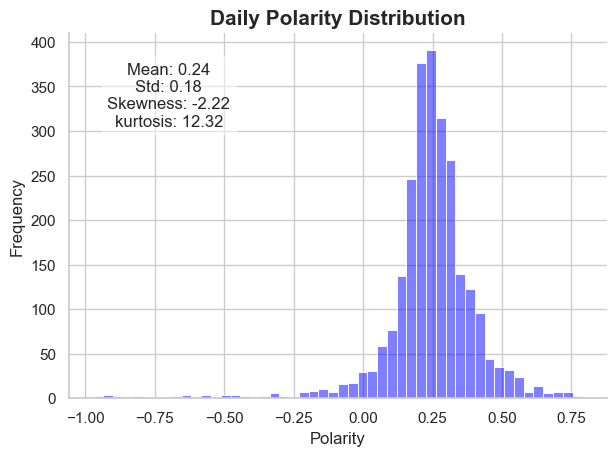

Percentage of positive polarity: 95.23%


In [419]:
sns.histplot(daily_entry_df['polarity'], bins=50, color='blue', edgecolor=None, alpha=0.5)
plt.title('Daily Polarity Distribution', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.xlabel('Polarity', fontdict={'fontsize': 12})
plt.ylabel('Frequency', fontdict={'fontsize': 12})
# Box around the text describing, mean, std, skew, kurtosis
plt.text(-0.7, 340, f'Mean: {daily_entry_df["polarity"].mean():.2f}\nStd: {daily_entry_df["polarity"].std():.2f}\nSkewness: {daily_entry_df["polarity"].skew():.2f}\nkurtosis: {daily_entry_df["polarity"].kurtosis():.2f}', 
         horizontalalignment='center', verticalalignment='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()
percent_above_zero = (daily_entry_df['polarity'] > 0).mean() * 100
print(f"Percentage of positive polarity: {percent_above_zero:.2f}%")

/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_900/1370603090.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "activity": daily_entry_df.groupby(pd.Grouper(key='Date', freq='Y'))['activity'].sum().values.tolist(),
/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_900/1370603090.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "year": daily_entry_df.groupby(pd.Grouper(key='Date', freq='Y'))['activity'].sum().index.year.tolist()
/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_900/1370603090.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_comment_counts, x='year', y='activity', palette=palette)


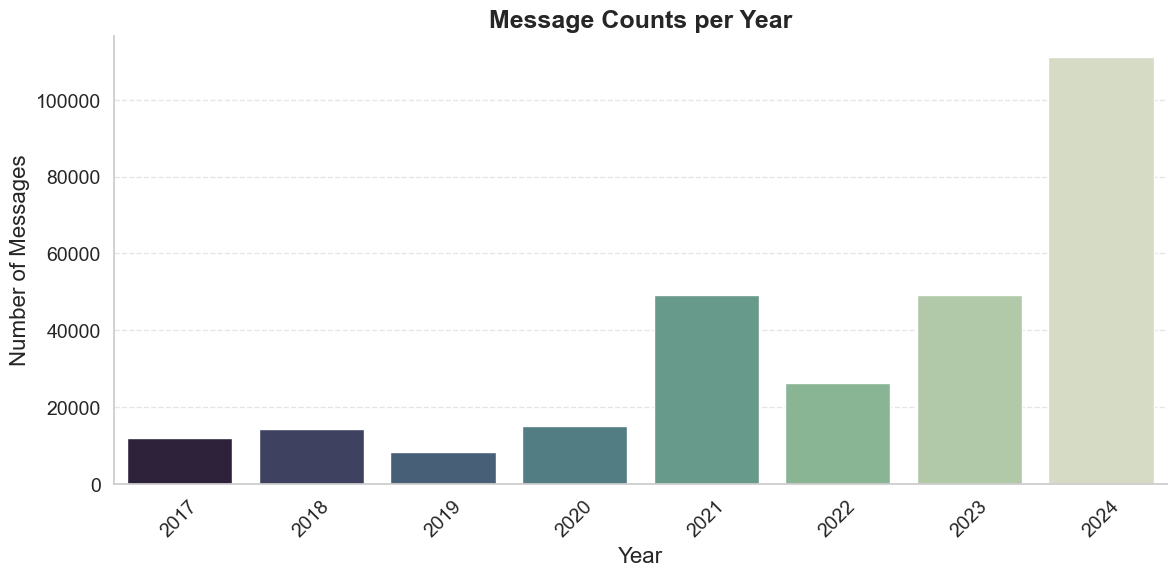

In [420]:
daily_entry_df['Date'] = pd.to_datetime(daily_entry_df['Date'])

yearly_comment_counts = pd.DataFrame(
    {
        "activity": daily_entry_df.groupby(pd.Grouper(key='Date', freq='Y'))['activity'].sum().values.tolist(),
        "year": daily_entry_df.groupby(pd.Grouper(key='Date', freq='Y'))['activity'].sum().index.year.tolist()
    }
)

palette = sns.cubehelix_palette(n_colors=len(yearly_comment_counts), start=0.5, rot=-0.75, reverse=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_comment_counts, x='year', y='activity', palette=palette)

plt.title('Message Counts per Year', fontsize=18, weight='bold')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Messages', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()


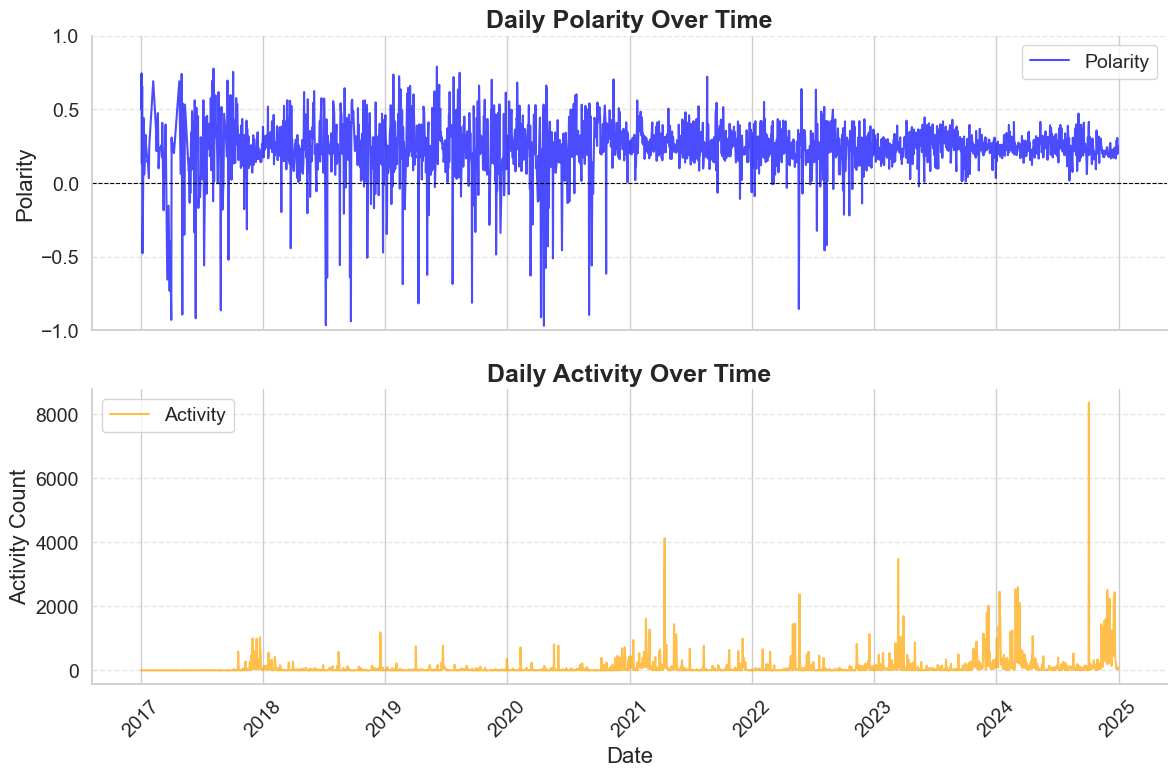

In [421]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plot polarity on top
sns.lineplot(data=daily_entry_df, x='Date', y='polarity',
             color='blue', label='Polarity', alpha=0.7, ax=ax1)
ax1.set_ylabel('Polarity', fontsize=16)
ax1.set_title('Daily Polarity Over Time', fontsize=18, weight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax1.tick_params(axis='x', labelrotation=45, labelsize=14)
ax1.tick_params(axis='y', labelsize=14)      # ← here
ax1.set_ylim(-1, 1)
ax1.legend(fontsize=14)

# Plot activity on bottom
sns.lineplot(data=daily_entry_df, x='Date', y='activity',
             color='orange', label='Activity', alpha=0.7, ax=ax2)
ax2.set_ylabel('Activity Count', fontsize=16)
ax2.set_title('Daily Activity Over Time', fontsize=18, weight='bold')
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.set_xlabel('Date', fontsize=16)
ax2.tick_params(axis='x', labelrotation=45, labelsize=14)  # ← here
ax2.tick_params(axis='y', labelsize=14)                   # ← here
ax2.legend(fontsize=14)

# Clean layout
sns.despine()
fig.tight_layout()
plt.show()

In [422]:
df3.columns

Index(['polarity', 'Date', 'log_pos/neg_ratio', 'activity',
       '5_day_activity_pct_change', 'activity_z20', '5_day_delta_polarity',
       '20_day_z_score_polarity', 'max_posneg_ratio', 'polarity_x_activity',
       'polarity_t-1', 'polarity_t-2', 'Close', 'Close_z20', '5_day_returns',
       'Close-MA_20', 'Open_Close_diff', 'Volume_z20', '5_Day_Delta_Volume',
       'Volume-MA_20', '5_Day_Delta_RSI', 'RSI-50', 'Momentum',
       '5_Day_Delta_Momentum', '20_day_volatility'],
      dtype='object')

In [ ]:
df3['y_up'] = np.where(df3[f"{H}_day_returns"] > 0, 1, 0) # 1 if price goes up, 0 if it goes down

q_70 = int(len(df3) * 0.7)

train_mask = (df3['Date'] >= pd.to_datetime('2017-01-01').date()) & (df3['Date'] < pd.to_datetime('2023-01-01').date())
val_mask = (df3['Date'] >= pd.to_datetime('2023-01-01').date()) & (df3['Date'] < pd.to_datetime('2024-01-01').date())
test_mask = df3['Date'] >= pd.to_datetime('2024-01-01').date()


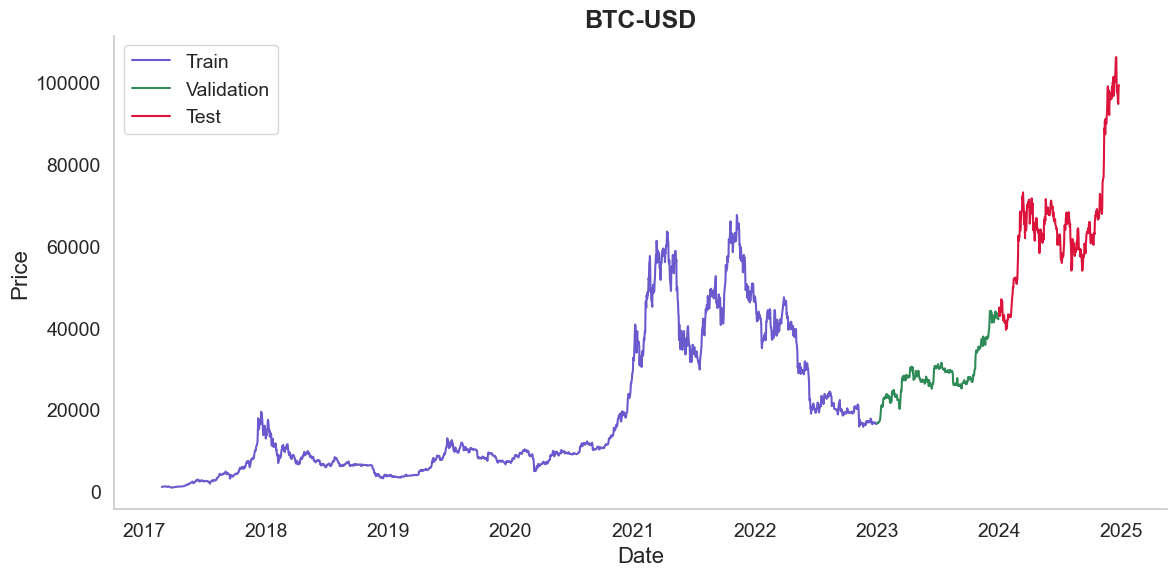

In [425]:
plt.figure(figsize=(12, 6))
plt.title('BTC-USD', fontsize=18, weight='bold')

# Plot with seaborn lineplot for each split
sns.lineplot(data=df3.loc[train_mask], x='Date', y='Close', label='Train', color='slateblue')
sns.lineplot(data=df3.loc[val_mask], x='Date', y='Close', label='Validation', color='seagreen')
sns.lineplot(data=df3.loc[test_mask], x='Date', y='Close', label='Test', color='crimson')

plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
sns.despine()
plt.show()


/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_900/2522350561.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


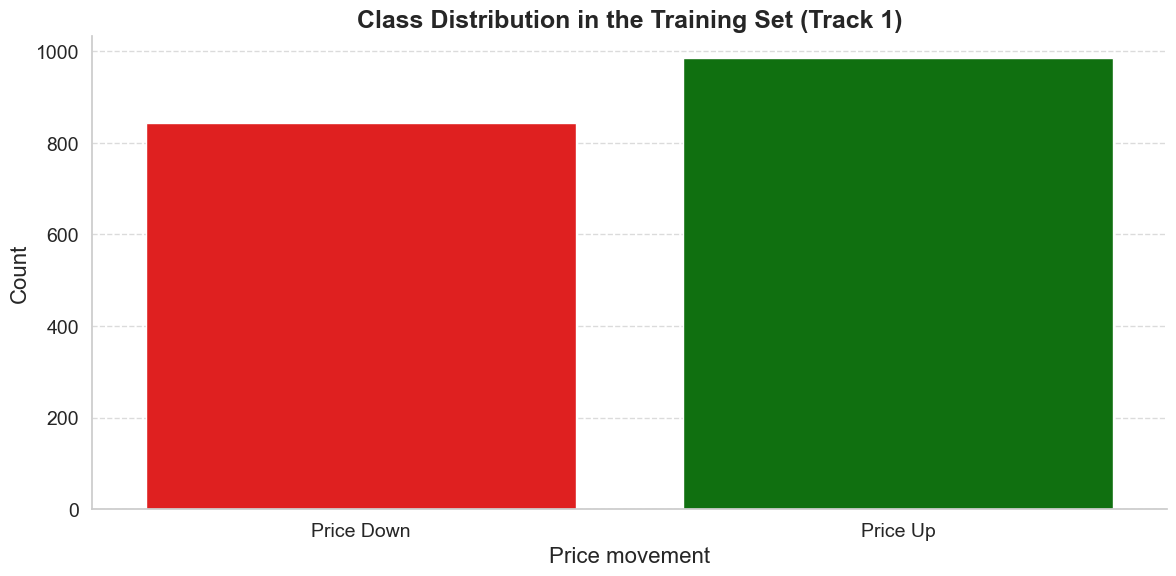

In [428]:
plt.figure(figsize=(12, 6))
plt.title("Class Distribution in the Training Set (Track 1)", fontsize=18, weight='bold')

sns.countplot(
    data=df3.loc[train_mask],
    x='y_up',
    palette={'0': 'red', '1': 'green'}
)

plt.xlabel('Price movement', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Price Down', 'Price Up'], fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
sns.despine()
plt.show()

## Training the sentiment-enhanced model

In [ ]:
X = df3.drop(columns=['Close', 'Date', f"{H}_day_returns", 'y_up'])

y = df3['y_up'].copy()

X_train = X.loc[train_mask, :]
y_train = y.loc[train_mask]

X_val = X.loc[val_mask, :]
y_val = y.loc[val_mask]

X_test = X.loc[test_mask, :]
y_test = y.loc[test_mask]

model = RandomForestClassifier(random_state=42, class_weight='balanced')

tscv = TimeSeriesSplit(n_splits=5, gap=5)
param_grid = {
    'max_depth': [4, 8, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', None],
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
)

n_models = len(ParameterGrid(param_grid)) * tscv.get_n_splits()

# Used to create a tqdm progress bar for joblib
@contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager: patch joblib to report into tqdm progress bar."""
    class TqdmBatch(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatch
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

with tqdm_joblib(tqdm(total=n_models, desc="Grid-search")):
    grid.fit(X_train, y_train)
    
best_clf = grid.best_estimator_


best_clf.fit(X_train, y_train)

Grid-search: 100%|██████████| 1080/1080 [02:50<00:00,  6.35it/s]


RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=None,
                       min_samples_leaf=2, min_samples_split=8,
                       random_state=42)

In [430]:
print(f"Best parameters: {grid.best_params_}")

Best parameters: {'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}


In [ ]:
start_date = df3.iloc[0]['Date']
end_date = df3.iloc[-1]['Date']

df_start_index = df.loc[df['Date'] == start_date, :].index[0]
df_end_index = df.loc[df['Date'] == end_date, :].index[0]
#df.iloc[df_start_index:df_end_index+1, :]

train_start_date = df3.loc[train_mask, 'Date'].tolist()[0]
train_end_date = df3.loc[train_mask, 'Date'].tolist()[-1]

train_start_index = df.loc[df['Date'] == train_start_date, :].index[0]
train_end_index = df.loc[df['Date'] == train_end_date, :].index[0]

validation_start_date = df3.loc[val_mask, 'Date'].tolist()[0]
validation_end_date = df3.loc[val_mask, 'Date'].tolist()[-1]

validation_start_index = df.loc[df['Date'] == validation_start_date, :].index[0]
validation_end_index = df.loc[df['Date'] == validation_end_date, :].index[0]

test_start_date = df3.loc[test_mask, 'Date'].tolist()[0]
test_end_date = df3.loc[test_mask, 'Date'].tolist()[-1]

test_start_index = df.loc[df['Date'] == test_start_date, :].index[0]
test_end_index = df.loc[df['Date'] == test_end_date, :].index[0]

df_train = df.iloc[train_start_index:train_end_index+1, :]
df_validation = df.iloc[validation_start_index:validation_end_index+1, :]
df_test = df.iloc[test_start_index:test_end_index+1, :]
df_train.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [434]:
print(f"Train set: {train_start_date} to {train_end_date}")
print(f"Validation set: {validation_start_date} to {validation_end_date}")
print(f"Test set: {test_start_date} to {test_end_date}")
print(f"The size of the training set is {len(df3.loc[train_mask, :])}, while there are {len(df_train)}, training days in this period.")
print(f"The size of the validation set is {len(df3.loc[val_mask, :])}, while there are {len(df_validation)}, training days in this period.")
print(f"The size of the test set is {len(df3.loc[test_mask, :])}, while there are {len(df_test)}, training days in this period.")

Train set: 2017-02-22 to 2022-12-31
Validation set: 2023-01-02 to 2023-12-31
Test set: 2024-01-01 to 2024-12-25
The size of the training set is 1828, while there are 2139, training days in this period.
The size of the validation set is 364, while there are 364, training days in this period.
The size of the test set is 360, while there are 360, training days in this period.


We see that the data availability is not a problem for the val-test sets, meaning the simulations reflect all trading days (unlike for the train set, which worsens the model a bit)

In [435]:
X_train = X.loc[train_mask, :]
y_train = y.loc[train_mask]

X_val = X.loc[val_mask, :]
y_val = y.loc[val_mask]

X_test = X.loc[test_mask, :]
y_test = y.loc[test_mask]

## Calibrating the threshold for best Sharpe on the validation set

In [ ]:
sigmoid_calibrator = CalibratedClassifierCV(
    estimator=best_clf,
    method='sigmoid',
    cv='prefit',
    n_jobs=-1
)

sigmoid_calibrator.fit(X_train, y_train)

proba_up_val = sigmoid_calibrator.predict_proba(X_val)[:, 1]

p_limit_candidates = np.linspace(0.5, 0.7, 200)
best_score, best_p_limit = -np.inf, None

for p_limit in p_limit_candidates:

    y_pred_val = np.where(proba_up_val > p_limit, 1, 0)
    preds_df_val = df3.loc[val_mask].copy()
    preds_df_val['Signal'] = y_pred_val
    preds_df_val['Signal'] = preds_df_val['Signal'].shift(1)
    
    portfolio_df, entry_indices = simulate_strategy(preds_df_val, initial_cash=100_000, hold_days=H, trading_fee=0.00075)
    score = calculate_sharpe_ratio(portfolio_df['portfolio_value'].pct_change(), annual_risk_free_rate=0.05, mode='365')
    print(f"p_limit: {p_limit:.3f}, Sharpe Ratio: {score:.4f}")

    if score >= best_score:
        best_score = score
        best_p_limit = p_limit

p_limit = best_p_limit
print(f"Best p_limit: {p_limit:.3f}")
y_pred_val = sigmoid_calibrator.predict_proba(X_val)[:, 1]
y_pred_val = np.where(y_pred_val > p_limit, 1, 0)

p_limit: 0.500, Sharpe Ratio: 1.4052
p_limit: 0.501, Sharpe Ratio: 1.4052
p_limit: 0.502, Sharpe Ratio: 1.4940
p_limit: 0.503, Sharpe Ratio: 1.5079
p_limit: 0.504, Sharpe Ratio: 1.5079
p_limit: 0.505, Sharpe Ratio: 1.5079
p_limit: 0.506, Sharpe Ratio: 1.5079
p_limit: 0.507, Sharpe Ratio: 1.5079


/Users/palbence/opt/anaconda3/envs/trading_env/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


p_limit: 0.508, Sharpe Ratio: 1.5079
p_limit: 0.509, Sharpe Ratio: 1.5079
p_limit: 0.510, Sharpe Ratio: 1.5079
p_limit: 0.511, Sharpe Ratio: 1.4880
p_limit: 0.512, Sharpe Ratio: 1.4880
p_limit: 0.513, Sharpe Ratio: 1.4880
p_limit: 0.514, Sharpe Ratio: 1.4880
p_limit: 0.515, Sharpe Ratio: 1.4880
p_limit: 0.516, Sharpe Ratio: 1.4880
p_limit: 0.517, Sharpe Ratio: 1.4880
p_limit: 0.518, Sharpe Ratio: 1.4880
p_limit: 0.519, Sharpe Ratio: 1.3319
p_limit: 0.520, Sharpe Ratio: 1.3319
p_limit: 0.521, Sharpe Ratio: 1.3319
p_limit: 0.522, Sharpe Ratio: 1.3319
p_limit: 0.523, Sharpe Ratio: 1.3319
p_limit: 0.524, Sharpe Ratio: 1.6010
p_limit: 0.525, Sharpe Ratio: 1.6010
p_limit: 0.526, Sharpe Ratio: 1.6010
p_limit: 0.527, Sharpe Ratio: 1.6010
p_limit: 0.528, Sharpe Ratio: 1.6010
p_limit: 0.529, Sharpe Ratio: 1.6010
p_limit: 0.530, Sharpe Ratio: 1.6010
p_limit: 0.531, Sharpe Ratio: 1.6010
p_limit: 0.532, Sharpe Ratio: 1.6010
p_limit: 0.533, Sharpe Ratio: 1.6010
p_limit: 0.534, Sharpe Ratio: 1.6010
p

In [444]:
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

final_clf = RandomForestClassifier(**grid.best_params_, random_state=42, class_weight='balanced')
final_clf.fit(X_train_val, y_train_val)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=None,
                       min_samples_leaf=2, min_samples_split=8,
                       random_state=42)

In [445]:
proba_up_test = final_clf.predict_proba(X_test)[:,1]
y_pred  = (proba_up_test > p_limit).astype(int)

/Users/palbence/opt/anaconda3/envs/trading_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [446]:
#y_pred = np.where(proba_up > p_limit, 1, 0)
#y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

Accuracy: 0.49166666666666664
Precision: 0.8
Recall: 0.11940298507462686
F1 Score: 0.2077922077922078
ROC AUC Score: 0.5408335680090115


array([[153,   6],
       [177,  24]])

In [447]:
preds_df = df3.copy()
preds_df = preds_df.loc[test_mask, :]
preds_df['Signal'] = y_pred
preds_df['Signal'] = preds_df['Signal'].shift(1)
preds_df['Signal'].fillna(0, inplace=True)

preds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 2192 to 2551
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   polarity                   360 non-null    float64
 1   Date                       360 non-null    object 
 2   log_pos/neg_ratio          360 non-null    float64
 3   activity                   360 non-null    float64
 4   5_day_activity_pct_change  360 non-null    float64
 5   activity_z20               360 non-null    float64
 6   5_day_delta_polarity       360 non-null    float64
 7   20_day_z_score_polarity    360 non-null    float64
 8   max_posneg_ratio           360 non-null    float64
 9   polarity_x_activity        360 non-null    float64
 10  polarity_t-1               360 non-null    float64
 11  polarity_t-2               360 non-null    float64
 12  Close                      360 non-null    float64
 13  Close_z20                  360 non-null    float64


/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_900/1774041517.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preds_df['Signal'].fillna(0, inplace=True)


## Back-testing the predictions on the test set

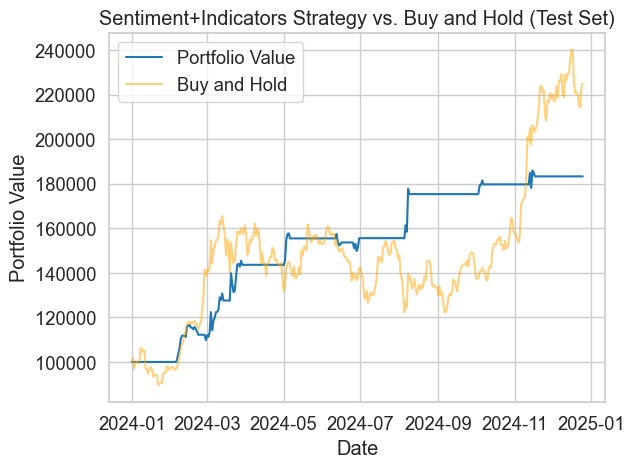

Sharpe Ratio: 2.3022


In [448]:
portfolio_sentiment, entry_indices_sentiment = simulate_strategy(preds_df, initial_cash=100_000, hold_days=H, trading_fee=0.00075)
preds_df['portfolio_value'] = portfolio_sentiment['portfolio_value']

test_dates = df3.loc[test_mask, 'Date'].values

signal_dates = preds_df.loc[preds_df['Signal'] == 0, 'Date'].values

plt.plot(test_dates, portfolio_sentiment['portfolio_value'], label='Portfolio Value')
#plt.plot(signal_dates, 100_000*preds_df[preds_df['Signal'] == 0]['Close']/preds_df['Close'].iloc[0], label='Buy Signal', marker='^', color='green', markersize=10, alpha=0.5, linestyle='None')
plt.plot(test_dates, 100_000 * portfolio_sentiment['Close']/portfolio_sentiment['Close'].iloc[0] , label='Buy and Hold', color='orange', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Portfolio Value')

plt.title("Sentiment+Indicators Strategy vs. Buy and Hold (Test Set)")

plt.legend()

plt.show()

sharpe_ratio = calculate_sharpe_ratio(portfolio_sentiment['portfolio_value'].pct_change().dropna(), annual_risk_free_rate=0.05, mode='365')
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

#### Due to the duration of running the code the windows were manually changed as it would have been a lot of memory usage

In [ ]:
# saving the predictions
np.save(f'y_pred_sent_w{w}.npy', y_pred)
np.save(f'y_test_sent_w{w}.npy', y_test)

In [450]:
buy_and_hold_max_drawdown_test = calculate_sharpe_ratio(portfolio_sentiment['Close'].pct_change().dropna(), annual_risk_free_rate=0.05, mode='365')
print(f"Test Buy and Hold Sharpe Ratio: {buy_and_hold_max_drawdown_test:.4f}")

Test Buy and Hold Sharpe Ratio: 1.7083


In [ ]:
# saving the portfolio values
portfolio_sentiment.to_csv(f'portfolio_sentiment_{w}_window.csv', index=False)

In [453]:
max_drawdown = (portfolio_sentiment['portfolio_value'] / portfolio_sentiment['portfolio_value'].cummax() - 1).min()
print(f"Max Drawdown: {max_drawdown:.4%}")
buy_and_hold_max_drawdown = (100_000 * portfolio_sentiment['Close']/portfolio_sentiment['Close'].iloc[0] / (100_000 * portfolio_sentiment['Close']/portfolio_sentiment['Close'].iloc[0]).cummax() - 1).min()
print(f"Buy and Hold Max Drawdown: {buy_and_hold_max_drawdown:.4%}")

Max Drawdown: -6.6284%
Buy and Hold Max Drawdown: -26.1820%


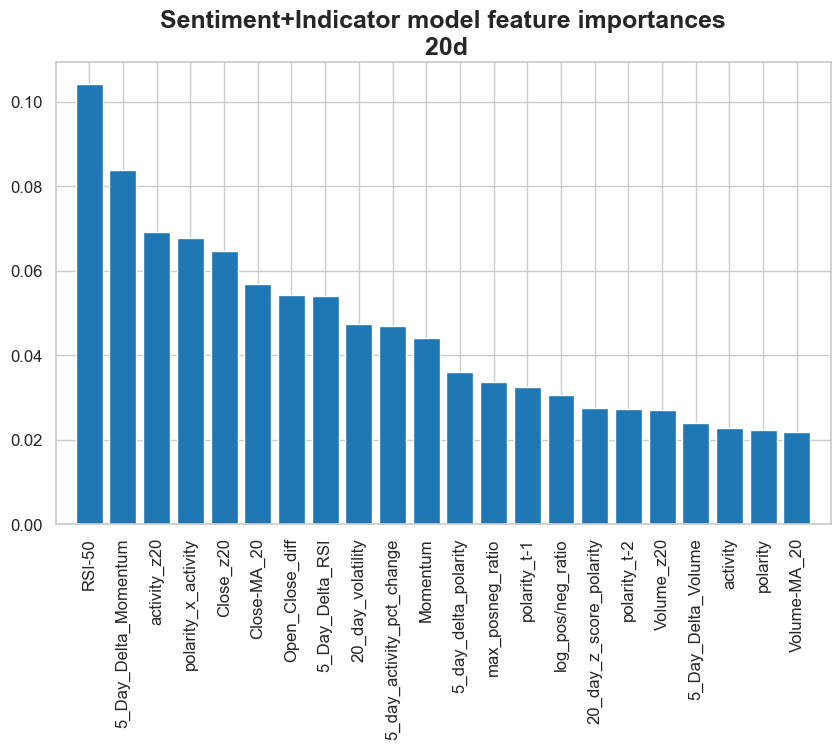

In [454]:
# Plot the feature importances in sorted order
importances = final_clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title(f"Sentiment+Indicator model feature importances\n {z}d", fontsize=18, weight='bold')
plt.bar(range(X_train.shape[1]), importances[indices], align="center")  
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [455]:
explainer_sent = shap.TreeExplainer(final_clf)
shap_values_sent = explainer_sent.shap_values(X_test)

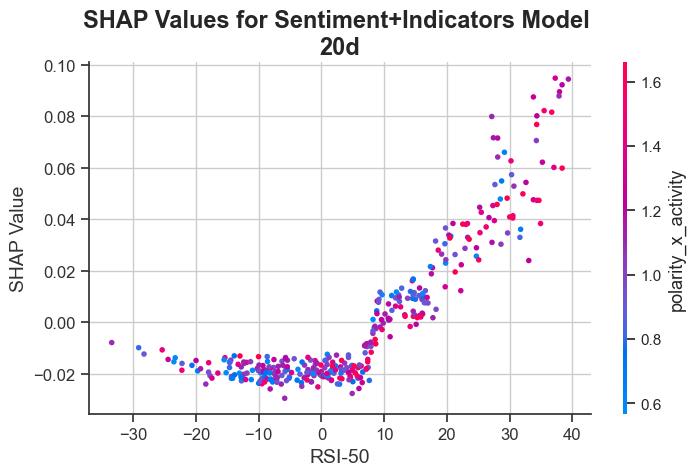

In [ ]:
shap.dependence_plot(
    'RSI-50',  # specify the feature for interaction
    shap_values_sent[:, :, 1],  # class 1 if you're using multiclass
    X_test,
    interaction_index=f'polarity_x_activity',  # specify the feature for interaction
    show=False  # prevent auto show so we can modify the plot
)

plt.title(f'SHAP Values for Sentiment+Indicators Model \n{w}d', fontsize=17, fontweight='bold')
plt.xlabel('RSI-50', fontsize=14)
plt.ylabel('SHAP Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


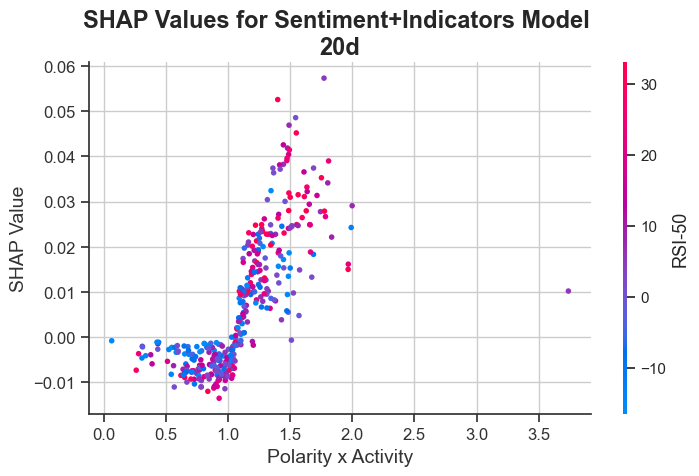

In [ ]:
shap.dependence_plot(
    'polarity_x_activity',  # specify the feature for interaction
    shap_values_sent[:, :, 1],  # class 1 if you're using multiclass
    X_test,
    interaction_index=f'RSI-50',  # specify the feature for interaction
    show=False  # prevent auto show so we can modify the plot
)

plt.title(f'SHAP Values for Sentiment+Indicators Model \n{w}d', fontsize=17, fontweight='bold')
plt.xlabel('Polarity x Activity', fontsize=14)
plt.ylabel('SHAP Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


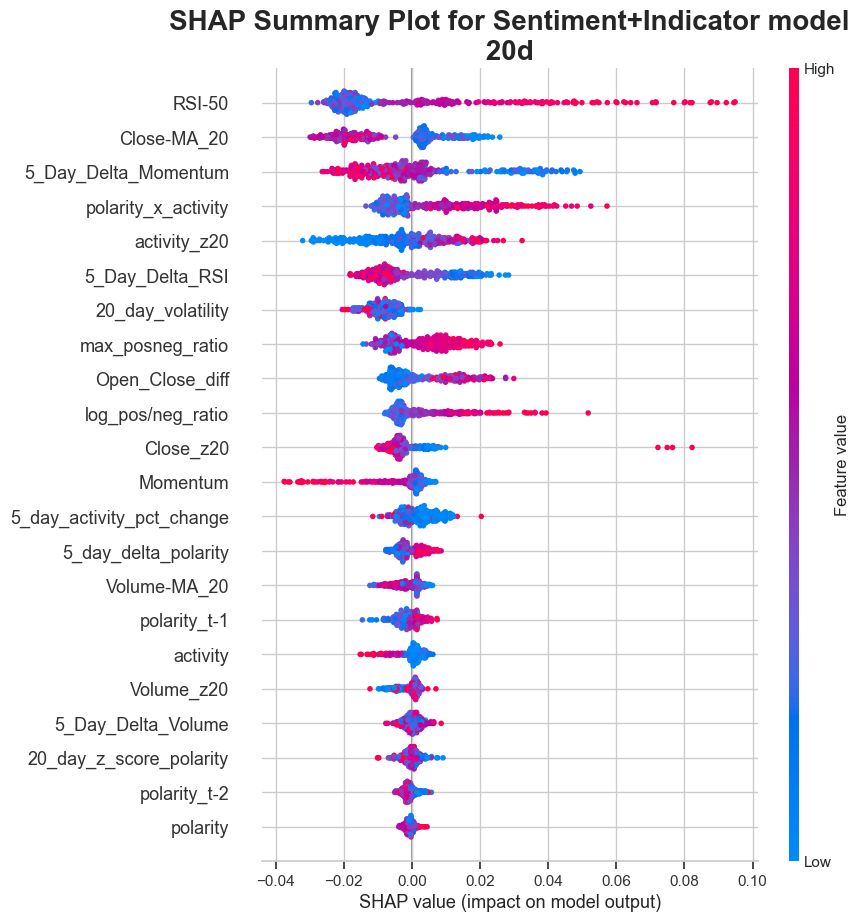

In [463]:
shap_explanation_sent = shap.Explanation(values=shap_values_sent,
                                          data=X_test,
                                          feature_names=X_test.columns.tolist(),)

plt.title(f"SHAP Summary Plot for Sentiment+Indicator model\n {z}d ", fontsize=20, weight='bold')
shap.plots.beeswarm(shap_explanation_sent[:, :, 1], max_display=30)

plt.show()

## Pure technical indicator

In [ ]:
X_ind = df3.drop(columns=['Close', 'Date', f"{H}_day_returns", 'y_up', 'polarity', f'{delta}_day_delta_polarity', f'{w}_day_z_score_polarity', 
       'log_pos/neg_ratio', 'activity', f'{delta}_day_activity_pct_change', 
       f'activity_z{w}', 'max_posneg_ratio', 'polarity_x_activity', 'polarity_t-1', 'polarity_t-2'])

y_ind = df3['y_up'].copy()

X_train_ind = X_ind.loc[train_mask, :]
y_train_ind = y_ind.loc[train_mask]

X_val_ind = X_ind.loc[val_mask, :]
y_val_ind = y_ind.loc[val_mask]

X_test_ind = X_ind.loc[test_mask, :]
y_test_ind = y_ind.loc[test_mask]

model = RandomForestClassifier(random_state=42, class_weight='balanced')

tscv = TimeSeriesSplit(n_splits=5, gap=5)
param_grid = {
    'max_depth': [4, 8, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', None],
}

grid_ind = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
)

n_models = len(ParameterGrid(param_grid)) * tscv.get_n_splits()

@contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager: patch joblib to report into tqdm progress bar."""
    class TqdmBatch(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatch
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

with tqdm_joblib(tqdm(total=n_models, desc="Grid-search")):
    grid_ind.fit(X_train_ind, y_train_ind)
    
best_clf_ind = grid_ind.best_estimator_


best_clf_ind.fit(X_train_ind, y_train_ind)

Grid-search: 100%|██████████| 1080/1080 [01:51<00:00,  9.67it/s]


RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=200, random_state=42)

In [468]:
print(f"Best parameters: {grid_ind.best_params_}")

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


## Calibrating threshold

In [ ]:
sigmoid_calibrator_ind = CalibratedClassifierCV(
    estimator=best_clf_ind,
    method='sigmoid',
    cv='prefit',
    n_jobs=-1
)

sigmoid_calibrator_ind.fit(X_train_ind, y_train_ind)

proba_up_val_ind = sigmoid_calibrator_ind.predict_proba(X_val_ind)[:, 1]

p_limit_candidates_ind = np.linspace(0.5, 0.7, 200)
best_score_ind, best_p_limit_ind = -np.inf, None

for p_limit_ind in p_limit_candidates_ind:

    y_pred_val_ind = np.where(proba_up_val_ind > p_limit_ind, 1, 0)
    
    preds_df_val_ind = df3.loc[val_mask].copy()
    preds_df_val_ind['Signal'] = y_pred_val_ind
    preds_df_val_ind['Signal'] = preds_df_val_ind['Signal'].shift(1)
    
    portfolio_df_val_ind, entry_indices_val_ind = simulate_strategy(preds_df_val_ind, initial_cash=100_000, hold_days=H, trading_fee=0.00075)
    score_ind = calculate_sharpe_ratio(portfolio_df_val_ind['portfolio_value'].pct_change().dropna(), annual_risk_free_rate=0.05, mode='365')
    
    print(f"p_limit: {p_limit_ind:.3f}, Sharpe Ratio: {score_ind:.4f}")
    if score_ind >= best_score_ind:
        best_score_ind = score_ind
        best_p_limit_ind = p_limit_ind

final_p_limit_ind = best_p_limit_ind
print(f"Best p_limit: {final_p_limit_ind:.3f}")

y_pred_val_ind = sigmoid_calibrator_ind.predict_proba(X_val_ind)[:, 1]
y_pred_val_ind = np.where(y_pred_val_ind > final_p_limit_ind, 1, 0)

In [476]:
X_train_val_ind = np.vstack((X_train_ind, X_val_ind))
y_train_val_ind = np.concatenate((y_train_ind, y_val_ind))

final_clf_ind = RandomForestClassifier(**grid_ind.best_params_, random_state=42, class_weight='balanced')
final_clf_ind.fit(X_train_val_ind, y_train_val_ind)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=200, random_state=42)

In [477]:
proba_up_test_ind = final_clf_ind.predict_proba(X_test_ind)[:,1]
y_pred_ind  = (proba_up_test_ind > final_p_limit_ind).astype(int)

/Users/palbence/opt/anaconda3/envs/trading_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [478]:
#y_pred = np.where(proba_up > p_limit, 1, 0)
#y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_test_ind, y_pred_ind))
print("Precision:", precision_score(y_test_ind, y_pred_ind))
print("Recall:", recall_score(y_test_ind, y_pred_ind))
print("F1 Score:", f1_score(y_test_ind, y_pred_ind))
print("ROC AUC Score:", roc_auc_score(y_test_ind, y_pred_ind))

confusion_matrix(y_test_ind, y_pred_ind)

Accuracy: 0.45555555555555555
Precision: 0.6190476190476191
Recall: 0.06467661691542288
F1 Score: 0.11711711711711711
ROC AUC Score: 0.507181075753309


array([[151,   8],
       [188,  13]])

In [ ]:
# Again save the results
np.save(f'y_pred_ind_w{w}.npy', y_pred_ind)
np.save(f'y_test_ind_w{w}.npy', y_test_ind) # just as a robustness check, it is the same as y_test_sent

In [480]:
preds_df_ind = df3.copy()
preds_df_ind = preds_df_ind.loc[test_mask, :]
preds_df_ind['Signal'] = y_pred_ind
preds_df_ind['Signal'] = preds_df_ind['Signal'].shift(1)
preds_df_ind['Signal'].fillna(0, inplace=True)

preds_df_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 2192 to 2551
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   polarity                   360 non-null    float64
 1   Date                       360 non-null    object 
 2   log_pos/neg_ratio          360 non-null    float64
 3   activity                   360 non-null    float64
 4   5_day_activity_pct_change  360 non-null    float64
 5   activity_z20               360 non-null    float64
 6   5_day_delta_polarity       360 non-null    float64
 7   20_day_z_score_polarity    360 non-null    float64
 8   max_posneg_ratio           360 non-null    float64
 9   polarity_x_activity        360 non-null    float64
 10  polarity_t-1               360 non-null    float64
 11  polarity_t-2               360 non-null    float64
 12  Close                      360 non-null    float64
 13  Close_z20                  360 non-null    float64


/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_900/3129408535.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preds_df_ind['Signal'].fillna(0, inplace=True)


### Back-testing the indicator-only strategy

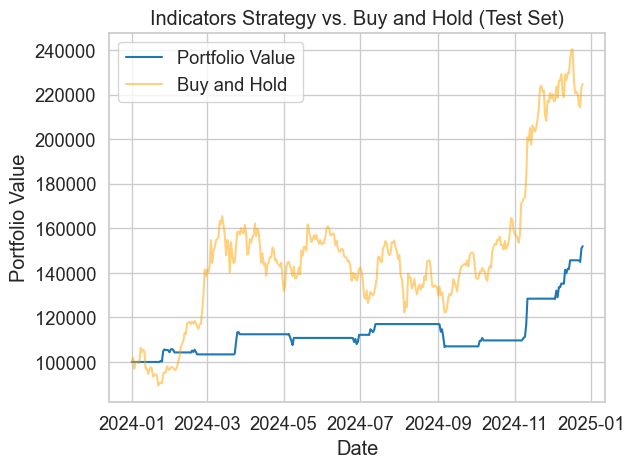

Sharpe Ratio: 2.0572


In [481]:
portfolio_ind, entry_indices_ind = simulate_strategy(preds_df_ind, initial_cash=100_000, hold_days=H, trading_fee=0.00075)
preds_df_ind['portfolio_value'] = portfolio_ind['portfolio_value']

test_dates = df3.loc[test_mask, 'Date'].values

signal_dates = preds_df_ind.loc[preds_df_ind['Signal'] == 0, 'Date'].values

plt.plot(test_dates, portfolio_ind['portfolio_value'], label='Portfolio Value')
#plt.plot(signal_dates, 100_000*preds_df[preds_df['Signal'] == 0]['Close']/preds_df['Close'].iloc[0], label='Buy Signal', marker='^', color='green', markersize=10, alpha=0.5, linestyle='None')
plt.plot(test_dates, 100_000 * portfolio_ind['Close']/portfolio_ind['Close'].iloc[0] , label='Buy and Hold', color='orange', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Portfolio Value')

plt.title("Indicators Strategy vs. Buy and Hold (Test Set)")

plt.legend()

plt.show()

sharpe_ratio_ind = calculate_sharpe_ratio(portfolio_ind['portfolio_value'].pct_change().dropna(), annual_risk_free_rate=0.05, mode='365')
print(f"Sharpe Ratio: {sharpe_ratio_ind:.4f}")

In [ ]:
portfolio_ind.to_csv(f'portfolio_indicators_{w}_window.csv', index=False)

In [483]:
max_drawdown_ind = (portfolio_ind['portfolio_value'] / portfolio_ind['portfolio_value'].cummax() - 1).min()
print(f"Max Drawdown: {max_drawdown_ind:.4%}")
buy_and_hold_max_drawdown_ind = (100_000 * portfolio_ind['Close']/portfolio_ind['Close'].iloc[0] / (100_000 * portfolio_ind['Close']/portfolio_ind['Close'].iloc[0]).cummax() - 1).min()
print(f"Buy and Hold Max Drawdown: {buy_and_hold_max_drawdown_ind:.4%}")

Max Drawdown: -8.8038%
Buy and Hold Max Drawdown: -26.1820%


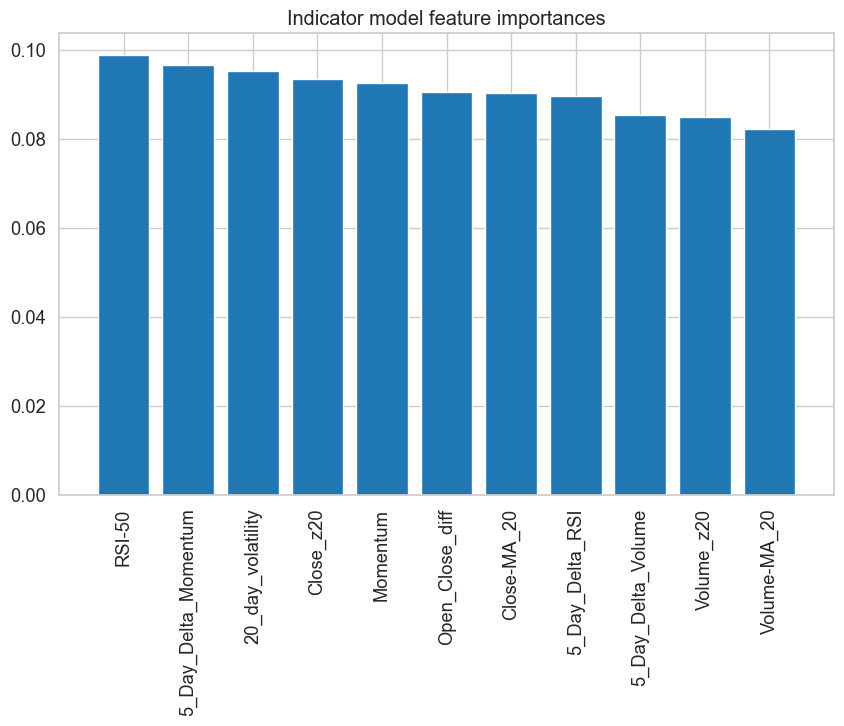

In [484]:
# Plot the feature importances in sorted order
importances = final_clf_ind.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Indicator model feature importances")
plt.bar(range(X_train_ind.shape[1]), importances[indices], align="center")  
plt.xticks(range(X_train_ind.shape[1]), X_train_ind.columns[indices], rotation=90)
plt.xlim([-1, X_train_ind.shape[1]])
plt.show()

In [489]:
def calculate_max_drawdown(returns):
    """
    Calculate the maximum drawdown of a series of returns.
    
    Parameters:
    returns (pd.Series): Series of returns.
    
    Returns:
    float: Maximum drawdown.
    """
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

def calculate_hit_rate(df, signal_col='Signal', target_col=f"{H}_day_returns", threshold=0.01, trade_indices=None):
    """
    Calculate the hit rate of a trading strategy.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the signals and target returns.
    signal_col (str): Column name for the trading signal (1 for buy, -1 for sell).
    target_col (str): Column name for the target returns.
    threshold (float): Minimum return to consider a hit.
    
    Returns:
    float: Hit rate as a percentage.
    """
    hits = []
    for trade_index in trade_indices:
        if df[signal_col].iloc[trade_index] == 1:
            if df[target_col].iloc[trade_index] > threshold:
                hits.append(1)
            else:
                hits.append(0)
                
    total_trades = len(hits)
    sum_hits = sum(np.array(hits))
    
    hit_rate = sum_hits / total_trades if total_trades > 0 else 0
    return hit_rate

def calculate_mean_net(df, signal_col='Signal', target_col=f"{H}_day_returns", entry_indices=None):
    """
    Calculate the mean net return of a trading strategy.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the signals and target returns.
    signal_col (str): Column name for the trading signal (1 for buy, -1 for sell).
    target_col (str): Column name for the target returns.
    
    Returns:
    float: Mean net return.
    """
    net_returns = []
    
    for entry_index in entry_indices:
        net_return = df[target_col].iloc[entry_index]
        net_returns.append(net_return)
        
    mean_net_return = np.mean(net_returns)
    return mean_net_return

In [490]:
trade_indices_indicator = set()

for element in entry_indices_ind:
    for key, value in element.items():

        trade_indices_indicator.add(key)
        
trade_indices_sentiment = set()
for element in entry_indices_sentiment:
    for key, value in element.items():

        trade_indices_sentiment.add(key)
        
trade_indices_indicator.discard(None)
trade_indices_sentiment.discard(None)

trade_indices_indicator = sorted(list(trade_indices_indicator))
trade_indices_sentiment = sorted(list(trade_indices_sentiment))

In [491]:
portfolio_ind.reset_index(drop=True, inplace=True)
portfolio_sentiment.reset_index(drop=True, inplace=True)

In [ ]:
# Saving the trade indices
np.save(f'trade_indices_indicator_{w}_window.npy', trade_indices_indicator)
np.save(f'trade_indices_sentiment_{w}_window.npy', trade_indices_sentiment)

[22, 29, 47, 81, 124, 176, 189, 245, 275, 310, 337, 344, 356]


In [493]:
summary = pd.DataFrame({
    'Trades': [len(trade_indices_indicator),
               len(trade_indices_sentiment)],
    'HitRate': [calculate_hit_rate(portfolio_ind, signal_col='Signal', target_col=f"{H}_day_returns", threshold=0, trade_indices=trade_indices_indicator),
                calculate_hit_rate(portfolio_sentiment, signal_col='Signal', target_col=f"{H}_day_returns", threshold=0, trade_indices=trade_indices_sentiment)],
    'MeanNet': [calculate_mean_net(portfolio_ind, signal_col='Signal', target_col=f"{H}_day_returns", entry_indices=trade_indices_indicator),
                calculate_mean_net(portfolio_sentiment, signal_col='Signal', target_col=f"{H}_day_returns", entry_indices=trade_indices_sentiment)],
    'Sharpe':  [calculate_sharpe_ratio(portfolio_ind['portfolio_value'].pct_change().dropna(), annual_risk_free_rate=0.05, mode='365'),
                calculate_sharpe_ratio(portfolio_sentiment['portfolio_value'].pct_change().dropna(), annual_risk_free_rate=0.05, mode='365')],
    'MaxDD':   [calculate_max_drawdown(portfolio_ind['portfolio_value'].pct_change().dropna()),
                calculate_max_drawdown(portfolio_sentiment['portfolio_value'].pct_change().dropna())],
    'TotalReturn': [portfolio_ind['portfolio_value'].iloc[-1] / portfolio_ind['portfolio_value'].iloc[0] - 1,
                    portfolio_sentiment['portfolio_value'].iloc[-1] / portfolio_sentiment['portfolio_value'].iloc[0] - 1],
                
}, index=['Indicator','Indicator+Sentiment'])
print(summary.round(4))


                     Trades  HitRate  MeanNet  Sharpe   MaxDD  TotalReturn
Indicator                13   0.6154   0.0317  2.0572 -0.0880       0.5197
Indicator+Sentiment      14   0.8571   0.0468  2.3022 -0.0663       0.8332


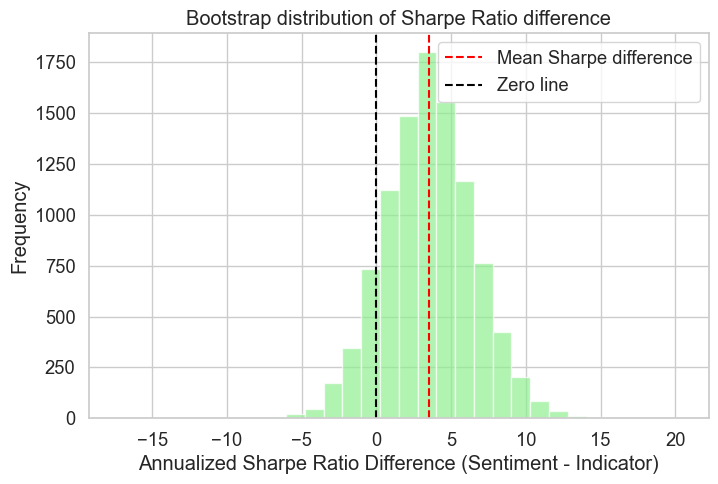

Bootstrap 95% CI of Sharpe difference (Sentiment - MACD): [-2.34, 9.50]
Estimated probability Sharpe(Sentiment) > Sharpe(MACD): 88.3%


In [ ]:
indicator_returns = portfolio_ind.iloc[trade_indices_indicator][f"{H}_day_returns"].dropna()
sentiment_returns = portfolio_sentiment.iloc[trade_indices_sentiment][f"{H}_day_returns"].dropna()

annual_factor = 365 / H  # Assuming daily returns, adjust for annualization

# Assuming you have sentiment_returns and macd_returns (both are 7-day trade returns)
bs_sent = IIDBootstrap(sentiment_returns)
bs_indicator = IIDBootstrap(indicator_returns)

n_reps = 10_000
boot_diff_sharpes = np.empty(n_reps)

for i in range(n_reps):
    sample_sent = next(bs_sent.bootstrap(1))[0]
    sample_ind = next(bs_indicator.bootstrap(1))[0]
    
    sr_sent = np.mean(sample_sent) / np.std(sample_sent, ddof=1)
    sr_ind = np.mean(sample_ind) / np.std(sample_ind, ddof=1)
    
    boot_diff_sharpes[i] = (sr_sent - sr_ind) * annual_factor  # Annualized difference

# Plot the difference distribution
plt.figure(figsize=(8, 5))
plt.hist(boot_diff_sharpes, bins=30, color='lightgreen', alpha=0.7)
plt.axvline(np.mean(boot_diff_sharpes), color='red', linestyle='--', label='Mean Sharpe difference')
plt.axvline(0, color='black', linestyle='--', label='Zero line')
plt.xlabel('Annualized Sharpe Ratio Difference (Sentiment - Indicator)')
plt.ylabel('Frequency')
plt.title('Bootstrap distribution of Sharpe Ratio difference')
plt.legend()
plt.grid(True)
plt.show()

# CI of the difference
ci_lower = np.percentile(boot_diff_sharpes, 2.5)
ci_upper = np.percentile(boot_diff_sharpes, 97.5)
print(f"Bootstrap 95% CI of Sharpe difference (Sentiment - MACD): [{ci_lower:.2f}, {ci_upper:.2f}]")

# Probability that Sentiment > MACD
prob_superior = np.mean(boot_diff_sharpes > 0)
print(f"Estimated probability Sharpe(Sentiment) > Sharpe(MACD): {prob_superior*100:.1f}%")


In [ ]:
lb_result = acorr_ljungbox(indicator_returns, lags=[5], return_df=True)

# Access the first row's statistic and p-value
print(f"Ljung-Box test statistic: {lb_result['lb_stat'].iloc[0]:.4f}, p-value: {lb_result['lb_pvalue'].iloc[0]:.4f}")


Ljung-Box test statistic: 3.3779, p-value: 0.6419


In [ ]:
lb_result = acorr_ljungbox(sentiment_returns, lags=[5], return_df=True)

# Access the first row's statistic and p-value
print(f"Ljung-Box test statistic: {lb_result['lb_stat'].iloc[0]:.4f}, p-value: {lb_result['lb_pvalue'].iloc[0]:.4f}")


Ljung-Box test statistic: 9.1205, p-value: 0.1044


In [ ]:
first_half = indicator_returns[:len(indicator_returns)//2] 
second_half = indicator_returns[len(indicator_returns)//2:]
ks_stat, p_value = ks_2samp(first_half, second_half)  

print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS Statistic: 0.3810, p-value: 0.6224


## Using the saved window data I create the plots

In [ ]:
windows = [10, 15, 20]
H = 5

equity_curves = {
    "10": {
        "indicator": None,
        "sentiment": None,
        "buyandhold": None
    },
    "15": {
        "indicator": None,
        "sentiment": None,
        "buyandhold": None  # sanity check should be same as 10
    },
    "20": {
        "indicator": None,
        "sentiment": None,
        "buyandhold": None  # sanity check should be same as 10
    }
}


portfolios = {
    "10": {
        "indicator": None,
        "sentiment": None,
    },
    "15": {
        "indicator": None,
        "sentiment": None,
    },
    "20": {
        "indicator": None,
        "sentiment": None,
    }
}

trade_indices = {
    "10": {
        "indicator": None,
        "sentiment": None
    },
    "15": {
        "indicator": None,
        "sentiment": None
    },
    "20": {
        "indicator": None,
        "sentiment": None
    }
}

for w in windows:
    port_sent = pd.read_csv(f'./windowed_data_track_1/portfolio_sentiment_{w}_window.csv')
    port_ind = pd.read_csv(f'./windowed_data_track_1/portfolio_indicators_{w}_window.csv')
    trade_index_sent = np.load(f'./windowed_data_track_1/trade_indices_sentiment_{w}_window.npy', allow_pickle=True)
    trade_index_ind = np.load(f'./windowed_data_track_1/trade_indices_indicator_{w}_window.npy', allow_pickle=True)
    trade_indices[str(w)]['indicator'] = trade_index_ind
    trade_indices[str(w)]['sentiment'] = trade_index_sent
    equity_curves[str(w)]['indicator'] = port_ind['portfolio_value'].values
    equity_curves[str(w)]['sentiment'] = port_sent['portfolio_value'].values
    equity_curves[str(w)]['buyandhold'] = 100_000 * port_ind['Close'].values / port_ind['Close'].iloc[0]
    portfolios[str(w)]['indicator'] = port_ind
    portfolios[str(w)]['sentiment'] = port_sent

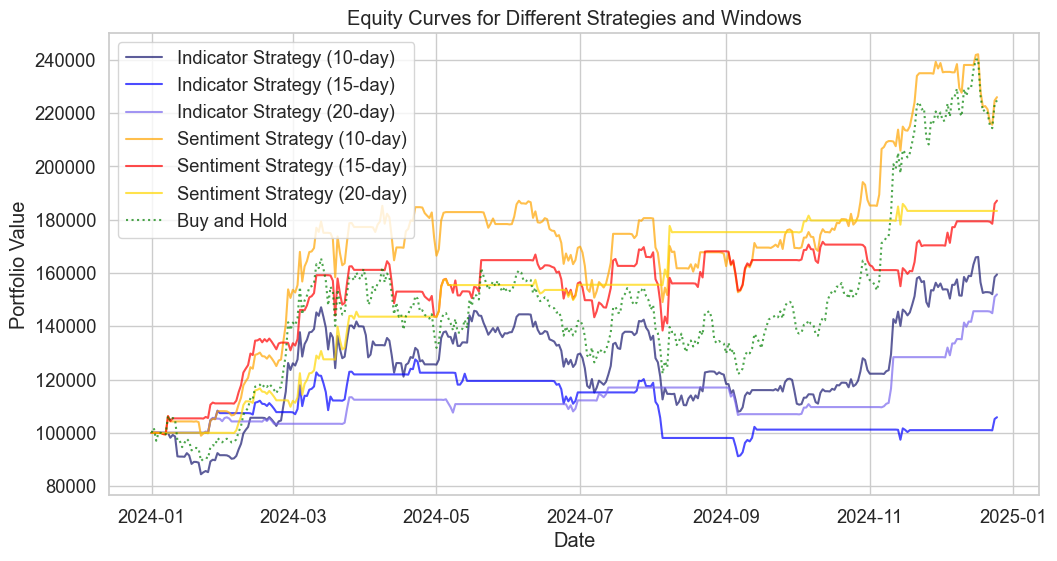

In [583]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.to_datetime(port_ind['Date']).dt.date, equity_curves['10']['indicator'], label='Indicator Strategy (10-day)', color='midnightblue', alpha=0.7)
plt.plot(pd.to_datetime(port_ind['Date']).dt.date, equity_curves['15']['indicator'], label='Indicator Strategy (15-day)', color='blue', alpha=0.7)
plt.plot(pd.to_datetime(port_ind['Date']).dt.date, equity_curves['20']['indicator'], label='Indicator Strategy (20-day)', color='mediumslateblue', alpha=0.7)
plt.plot(pd.to_datetime(port_sent['Date']).dt.date, equity_curves['10']['sentiment'], label='Sentiment Strategy (10-day)', color='orange', alpha=0.7)
plt.plot(pd.to_datetime(port_sent['Date']).dt.date, equity_curves['15']['sentiment'], label='Sentiment Strategy (15-day)', color='red', alpha=0.7)
plt.plot(pd.to_datetime(port_sent['Date']).dt.date, equity_curves['20']['sentiment'], label='Sentiment Strategy (20-day)', color='gold', alpha=0.7)
plt.plot(pd.to_datetime(port_ind['Date']).dt.date, equity_curves['10']['buyandhold'], label='Buy and Hold', color='green', linestyle=':', alpha=0.7)



plt.title('Equity Curves for Different Strategies and Windows')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

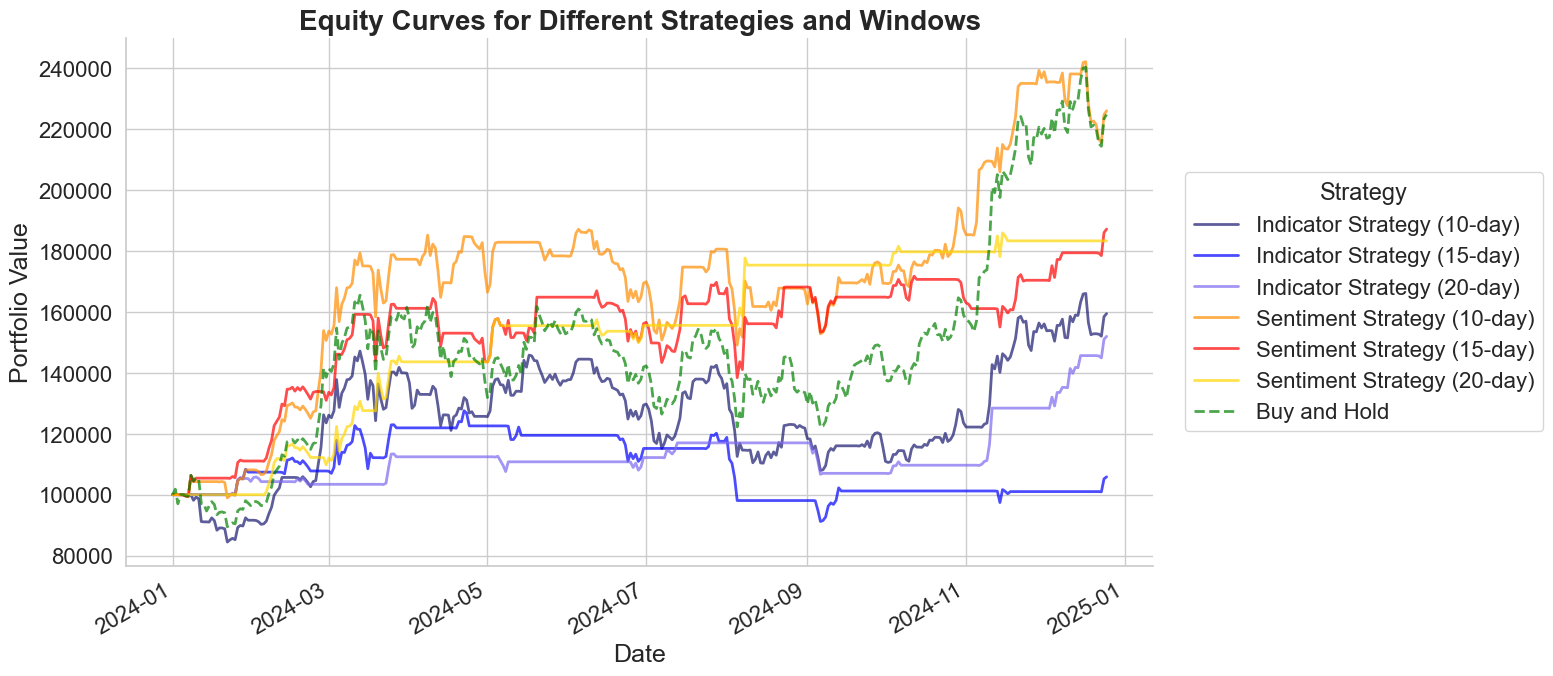

In [584]:
# Apply seaborn styling
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create figure
fig, ax = plt.subplots(figsize=(18, 7))

# Plot equity curves
ax.plot(pd.to_datetime(port_ind['Date']), equity_curves['10']['indicator'], label='Indicator Strategy (10-day)', color='midnightblue', alpha=0.7, linewidth=2)
ax.plot(pd.to_datetime(port_ind['Date']), equity_curves['15']['indicator'], label='Indicator Strategy (15-day)', color='blue', alpha=0.7, linewidth=2)
ax.plot(pd.to_datetime(port_ind['Date']), equity_curves['20']['indicator'], label='Indicator Strategy (20-day)', color='mediumslateblue', alpha=0.7, linewidth=2)

ax.plot(pd.to_datetime(port_sent['Date']), equity_curves['10']['sentiment'], label='Sentiment Strategy (10-day)', color='darkorange', alpha=0.7, linewidth=2)
ax.plot(pd.to_datetime(port_sent['Date']), equity_curves['15']['sentiment'], label='Sentiment Strategy (15-day)', color='red', alpha=0.7, linewidth=2)
ax.plot(pd.to_datetime(port_sent['Date']), equity_curves['20']['sentiment'], label='Sentiment Strategy (20-day)', color='gold', alpha=0.7, linewidth=2)

ax.plot(pd.to_datetime(port_ind['Date']), equity_curves['10']['buyandhold'], label='Buy and Hold', color='green', linestyle='--', alpha=0.7, linewidth=2)

# Titles and labels
ax.set_title('Equity Curves for Different Strategies and Windows', fontsize=20, weight='bold')
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Portfolio Value', fontsize=18)

# Improve legend positioning
ax.legend(title='Strategy', fontsize=16, title_fontsize=17, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True)

# Format ticks
ax.tick_params(axis='both', labelsize=16)
fig.autofmt_xdate()

# Tight layout for export
plt.tight_layout(rect=[0, 0, 0.88, 1])  # Leave space for legend
sns.despine()
plt.show()

In [ ]:
records = []
index_labels = []

for window in ["10", "15", "20"]:
    for model in ["indicator", "sentiment"]:
        label = "Indicator" if model == "indicator" else "Indicator+Sentiment"
        label = f"{window}d | {label}"

        df = portfolios[window][model]
        indices = trade_indices[window][model]

        returns = df['portfolio_value'].pct_change().dropna()
        total_return = df['portfolio_value'].iloc[-1] / df['portfolio_value'].iloc[0] - 1
        sharpe = calculate_sharpe_ratio(returns, annual_risk_free_rate=0.05, mode='365')
        maxdd = calculate_max_drawdown(returns)
        hitrate = calculate_hit_rate(df, signal_col='Signal', target_col=f"{H}_day_returns", threshold=0, trade_indices=indices)
        meannet = calculate_mean_net(df, signal_col='Signal', target_col=f"{H}_day_returns", entry_indices=indices)

        records.append([
            len(indices),
            hitrate,
            meannet,
            sharpe,
            maxdd,
            total_return
        ])
        index_labels.append(label)

# Build DataFrame
summary = pd.DataFrame(records, columns=[
    'Trades', 'HitRate', 'MeanNet', 'Sharpe', 'MaxDD', 'TotalReturn'
], index=index_labels)

print(summary.round(4))


                           Trades  HitRate  MeanNet  Sharpe   MaxDD  \
10d | Indicator                57   0.5614   0.0111  1.1369 -0.2664   
10d | Indicator+Sentiment      48   0.6875   0.0207  1.9882 -0.2033   
15d | Indicator                17   0.5882   0.0042  0.1596 -0.2850   
15d | Indicator+Sentiment      34   0.5588   0.0208  1.7443 -0.1845   
20d | Indicator                13   0.6154   0.0317  2.0572 -0.0880   
20d | Indicator+Sentiment      14   0.8571   0.0468  2.3022 -0.0663   

                           TotalReturn  
10d | Indicator                 0.5944  
10d | Indicator+Sentiment       1.2602  
15d | Indicator                 0.0585  
15d | Indicator+Sentiment       0.8719  
20d | Indicator                 0.5197  
20d | Indicator+Sentiment       0.8332  


In [ ]:
windows = [10, 15, 20]

results = {
    "10": {
        "indicator": None,
        "sentiment": None
    },
    "15": {
        "indicator": None,
        "sentiment": None
    },
    "20": {
        "indicator": None,
        "sentiment": None
    }
}

for w in windows:
    y_pred_ind_file = np.load(f'./windowed_data_track_1/y_pred_ind_w{w}.npy', allow_pickle=True)
    y_pred_sent_file = np.load(f'./windowed_data_track_1/y_pred_sent_w{w}.npy', allow_pickle=True)
    y_test_sent_file = np.load(f'./windowed_data_track_1/y_test_sent_w{w}.npy', allow_pickle=True)
    y_test_ind_file = np.load(f'./windowed_data_track_1/y_test_ind_w{w}.npy', allow_pickle=True)

    results[str(w)]['indicator'] = {
        'y_pred': y_pred_ind_file,
        'y_test': y_test_ind_file
    }
    results[str(w)]['sentiment'] = {
        'y_pred': y_pred_sent_file,
        'y_test': y_test_sent_file
    }


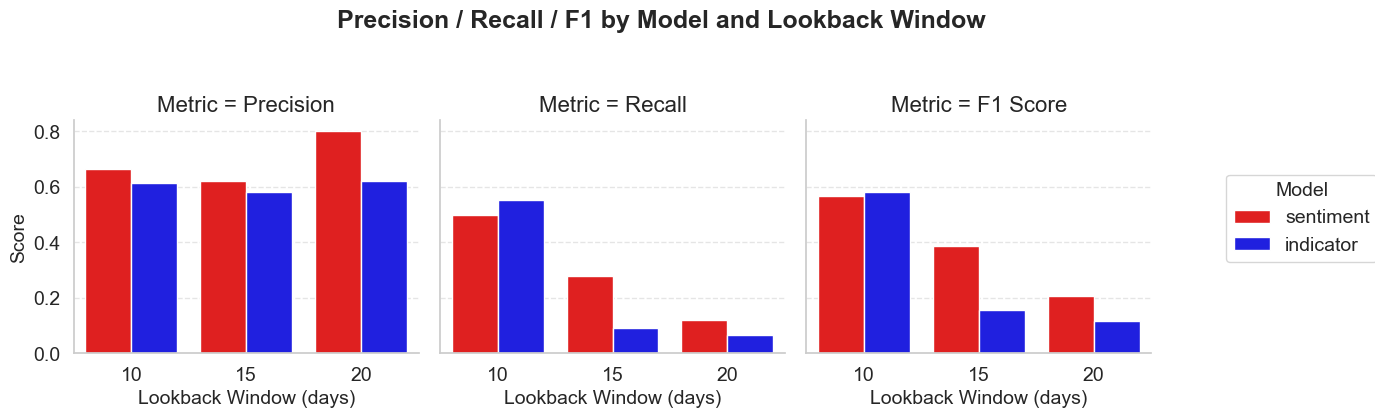

In [ ]:
# Setup
models   = ['sentiment', "indicator"]
windows = [10, 15, 20]

# Collect long-form data
rows = []
for model in models:
    for window in windows:
        y_true, y_pred = results[str(window)][model]['y_test'], results[str(window)][model]['y_pred']
        rows.extend([
            {"Model": model, "Window": window, "Metric": "Precision", "Score": precision_score(y_true, y_pred)},
            {"Model": model, "Window": window, "Metric": "Recall",    "Score": recall_score(y_true, y_pred)},
            {"Model": model, "Window": window, "Metric": "F1 Score",  "Score": f1_score(y_true, y_pred)},
        ])

df = pd.DataFrame(rows)
df['Window'] = pd.Categorical(df['Window'], categories=windows, ordered=True)

# Custom, high-contrast palette
model_palette = {
    'sentiment': 'red',  # ocean blue
    'indicator': 'blue',  # rich orange
}

# Define the exact hue order you want
hue_order = ['sentiment', 'indicator']

# Create the faceted barplots
g = sns.catplot(
    data=df,
    x="Window", y="Score",
    hue="Model",
    hue_order=hue_order,
    col="Metric",
    kind="bar",
    palette=model_palette,
    height=4, aspect=1
)

# Set titles, labels, font sizes
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_xlabel("Lookback Window (days)", fontsize=14)
    ax.set_ylabel("Score", fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Move legend outside the last subplot (to the right)
g._legend.set_title("Model", prop={'size': 14})
for text in g._legend.texts:
    text.set_fontsize(14)
g._legend.set_bbox_to_anchor((1.03, 0.5))  # move legend to right side
g._legend.set_frame_on(True)

# Add overall title
g.fig.suptitle("Precision / Recall / F1 by Model and Lookback Window", fontsize=18, weight='bold', y=1.05)

# Leave space for legend on the right
plt.tight_layout(rect=[0, 0, 0.88, 1])  # shrink the plot area a bit on the right
plt.show()

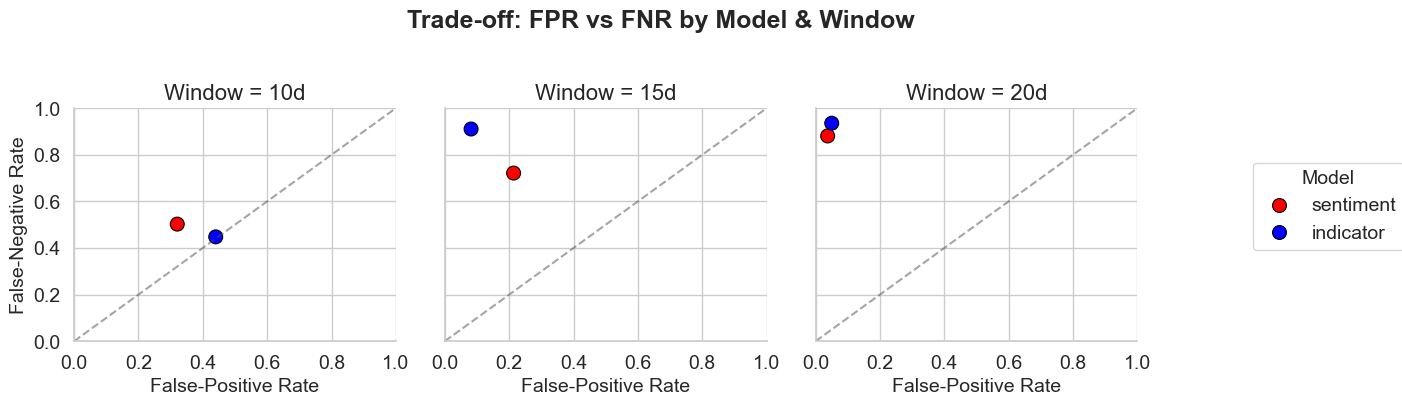

In [ ]:
# 1) Compute FPR & FNR
models   = ['sentiment', 'indicator']
windows = [10, 15, 20]

records = []
for model in models:
    for window in windows:
        y_true, y_pred = results[str(window)][model]['y_test'], results[str(window)][model]['y_pred']
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fpr = fp / (fp + tn) if (fp + tn) else 0
        fnr = fn / (fn + tp) if (fn + tp) else 0
        records.append({
            'Model': model,
            'Window': f"{window}d",
            'FPR': fpr,
            'FNR': fnr
        })

df_rates = pd.DataFrame(records)

# 2) Plot: FPR vs FNR, facet by window
sns.set_style("whitegrid")
g = sns.relplot(
    data=df_rates,
    x="FPR", y="FNR",
    hue="Model",
    palette={
        "sentiment": "red",
        "indicator": "blue"
    },
    col="Window",
    kind="scatter",
    edgecolor='black',
    linewidth=0.8,
    s=100,
    height=4, aspect=1
)

# 3) Tidy up
for ax in g.axes.flatten():
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.plot([0,1],[0,1], ls="--", c=".3", alpha=0.5)
    ax.set_xlabel("False-Positive Rate", fontsize=14)
    ax.set_ylabel("False-Negative Rate", fontsize=14)
    ax.tick_params(labelsize=14)

# Manually set the column titles (facet titles) to fontsize 16
for ax in g.axes.flatten():
    title = ax.get_title()
    ax.set_title(title, fontsize=16)

# Super-title
g.fig.suptitle("Trade-off: FPR vs FNR by Model & Window", fontsize=18, weight="bold", y=1.02)

# Legend outside the third plot
g._legend.set_title("Model", prop={'size': 14})
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_frame_on(True)

# Set legend label font size
for text in g._legend.texts:
    text.set_fontsize(14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

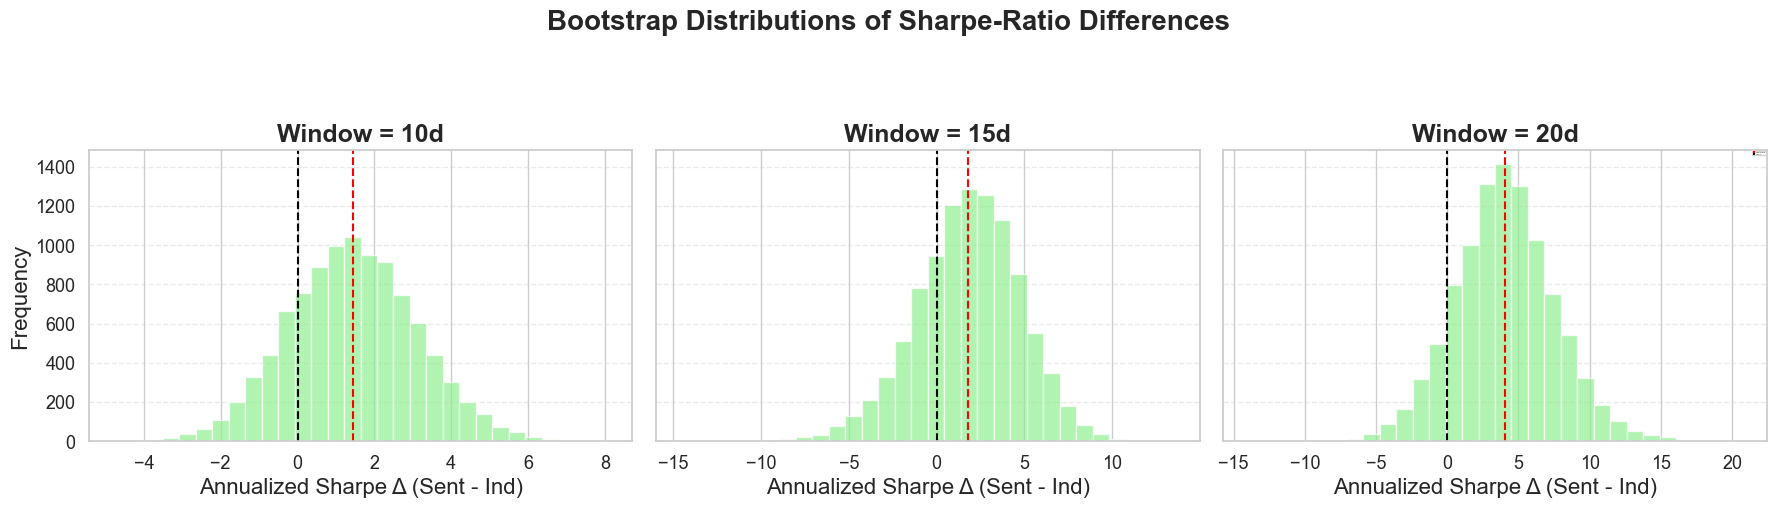

Window |   CI lower   |   CI upper   |  P(Δ>0)  | Wilcoxon p
 10d   |   -1.745   |    4.796   |   0.804   |   0.170
 15d   |   -4.441   |    7.298   |   0.743   |   0.202
 20d   |   -2.782   |    11.143   |   0.880   |   0.055

BH‐adjusted results (q=0.10):
Window  p_one-sided  p_BH(q=0.10)  Reject H₀?
    10        0.196         0.257       False
    15        0.257         0.257       False
    20        0.120         0.257       False


In [ ]:
windows = ['10', '15', '20']
n_reps = 10_000
annual_factor = np.sqrt(365 / H)

np.random.seed(42)

diffs_dict   = {}
p_one        = {}
p_wilcoxon   = {}

fig, axes = plt.subplots(1, len(windows), figsize=(6*len(windows), 5), sharey=True)
for ax, w in zip(axes, windows):
    # 1) Pull out the portfolio DataFrames and the trade‐entry indices
    df_ind  = portfolios[w]['indicator']
    df_sent = portfolios[w]['sentiment']
    idx_ind  = trade_indices[w]['indicator']
    idx_sent = trade_indices[w]['sentiment']

    # 2) Extract the H-day returns *at* those trade dates
    ind_rets  = df_ind .iloc[idx_ind] .loc[:, f"{H}_day_returns"].dropna().values
    sent_rets = df_sent.iloc[idx_sent].loc[:, f"{H}_day_returns"].dropna().values
    
    n_pair = min(len(ind_rets), len(sent_rets))
    stat, p_w = wilcoxon(sent_rets[:n_pair], ind_rets[:n_pair], alternative='greater')
    p_wilcoxon[w] = p_w

    # 3) Bootstrap sampler objects
    bs_ind  = IIDBootstrap(ind_rets)
    bs_sent = IIDBootstrap(sent_rets)

    # 4) Build the distribution of Sharpe differences
    diffs = np.empty(n_reps)
    for i in range(n_reps):
        samp_ind  = next(bs_ind.bootstrap(1))[0]
        samp_sent = next(bs_sent.bootstrap(1))[0]

        sr_ind  = np.mean(samp_ind)  / np.std(samp_ind,  ddof=1)
        sr_sent = np.mean(samp_sent) / np.std(samp_sent, ddof=1)

        diffs[i] = (sr_sent - sr_ind) * annual_factor
        
    diffs_dict[w] = diffs
    p_one[w]      = np.mean(diffs <= 0)  # one‐sided p‐value

    # 5) Plot on the shared‐y subplot
    ax.hist(diffs, bins=30, color='lightgreen', alpha=0.7)
    ax.axvline(np.mean(diffs), color='red',    linestyle='--', label='Mean ΔSharpe')
    ax.axvline(0,             color='black',  linestyle='--', label='Zero line')

    ax.set_title(f"Window = {w}d", fontsize=18, weight='bold')
    ax.set_xlabel("Annualized Sharpe Δ (Sent - Ind)", fontsize=16)
    if ax is axes[0]:
        ax.set_ylabel("Frequency", fontsize=16)
    ax.tick_params(labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='both', labelsize=13)

# 6) Shared legend, overall title, layout tweak
axes[-1].legend(fontsize=1, loc='upper right')
fig.suptitle("Bootstrap Distributions of Sharpe-Ratio Differences", fontsize=20, weight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# === 5.4.1: Bootstrap CI & P(Δ>0) & Wilcoxon ===
print("Window |   CI lower   |   CI upper   |  P(Δ>0)  | Wilcoxon p")
for w in windows:
    lower, upper = np.percentile(diffs_dict[w], [2.5, 97.5])
    prob_pos     = np.mean(diffs_dict[w] > 0)
    print(f" {w}d   |   {lower: .3f}   |   {upper: .3f}   |   {prob_pos:.3f}   |   {p_wilcoxon[w]:.3f}")

# === 5.4.2: One‐sided p‐values + BH correction ===
pv = [p_one[w] for w in windows]
reject, p_bh, _, _ = multipletests(pv, alpha=0.10, method='fdr_bh')

df_bh = pd.DataFrame({
    'Window':        windows,
    'p_one-sided':   pv,
    'p_BH(q=0.10)':  p_bh,
    'Reject H₀?':     reject
})
print("\nBH‐adjusted results (q=0.10):")
print(df_bh.to_string(index=False, float_format="%.3f"))

In [ ]:
windows  = ['10', '15', '20']
models   = ['indicator', 'sentiment']          
lags_lb  = [5]                                 # Ljung–Box lags
results  = []                                  # collect rows for a summary DataFrame

for w in windows:
    for m in models:
        # --- pull the H-day trade returns ------------------------------
        df   = portfolios[w][m]
        idx  = trade_indices[w][m]
        rets = df.iloc[idx][f"{H}_day_returns"].dropna().values
        
        # --- KS split-half test ---------------------------------------
        split         = len(rets) // 2
        ks_stat, ks_p = ks_2samp(rets[:split], rets[split:])
        
        # --- Ljung–Box test for serial correlation --------------------
        lb_df = acorr_ljungbox(rets, lags=lags_lb, return_df=True)
        lb_stat  = lb_df['lb_stat'].iloc[0]
        lb_pval  = lb_df['lb_pvalue'].iloc[0]
        
        # --- store ----------------------------------------------------
        results.append({
            'Window':  f'{w}d',
            'Model':   m,
            'n':       len(rets),
            'KS stat': ks_stat,
            'KS p':    ks_p,
            'LB stat': lb_stat,
            'LB p':    lb_pval
        })

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False, float_format='%.4f'))


Window     Model  n  KS stat   KS p  LB stat   LB p
   10d indicator 57   0.1564 0.8045   1.4425 0.9196
   10d sentiment 48   0.2083 0.6860   2.0782 0.8382
   15d indicator 17   0.5139 0.1732   5.2852 0.3821
   15d sentiment 34   0.2353 0.7506   7.5422 0.1833
   20d indicator 13   0.3810 0.6224   3.3779 0.6419
   20d sentiment 14   0.2857 0.9627   9.1205 0.1044
